# Keldy: Playground

## Imports & Setup Properties

In [1]:
import os
import sys
import glob
import copy
import itertools

import h5py

import math
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit

import mpi4py

### Plotting

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.print_figure_kwargs
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

In [3]:
#Plotting Options
markslist='o^v<>dhps*HD'
cmap = plt.get_cmap('plasma')
color_list_limit = 2

def f_colorlist(i, offset = 0, cycle = color_list_limit):
    return cmap(float((i+offset)%cycle) / cycle)

def f_markslist(i, offset = 0, cycle = color_list_limit):
    return markslist[((i+offset)%cycle)]

### Keldy Import

In [4]:
from pytriqs.gf import *
from pytriqs.plot.mpl_interface import oplot,plt

import keldy.impurity_oneband_module as k_imp

## Model g0

In [5]:
anderson_param = {
    "beta": 0.1, 
    "bias_V" : 0.0,
    "eps_d": 1.0,
    "Gamma": 0.5,
    "time_max": +10.0,
    "nr_time_points_gf": 5000
}

In [6]:
g0 = k_imp.G0Model(**anderson_param)

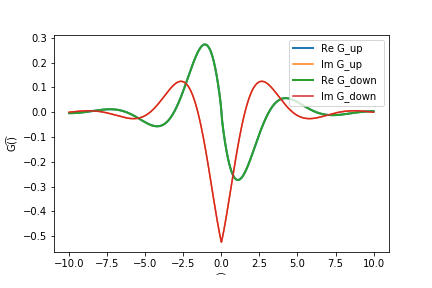

In [7]:
oplot(g0.g0_greater, '-', linewidth=2) 

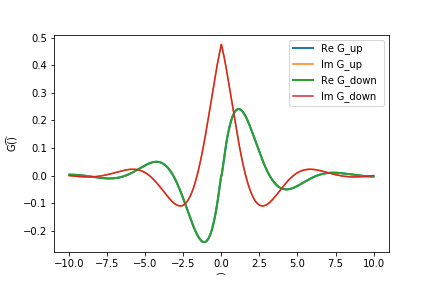

In [8]:
oplot(g0.g0_lesser, '-', linewidth=2) 

### Keldysh Adaptor

In [9]:
g0K = k_imp.G0KeldyshContourT(g0)

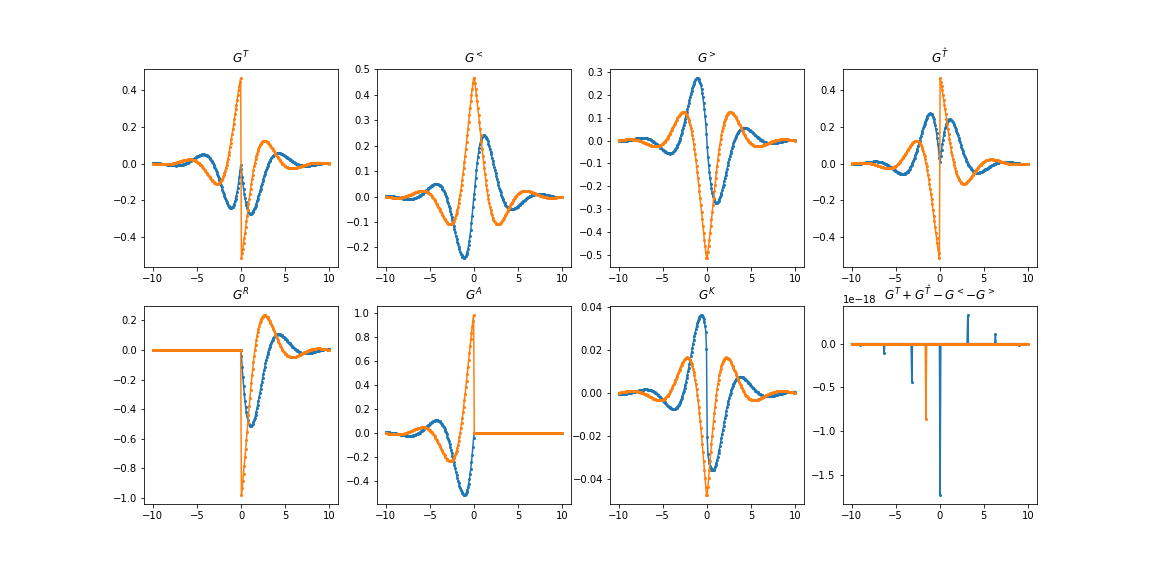

In [33]:
fig = plt.figure(figsize=(16,8))

t = np.linspace(-10,10,250)

g_ff = np.zeros(len(t), dtype='c16')
g_fb = np.zeros(len(t), dtype='c16')
g_bf = np.zeros(len(t), dtype='c16')
g_bb = np.zeros(len(t), dtype='c16')
gR = np.zeros(len(t), dtype='c16')
gA = np.zeros(len(t), dtype='c16')
gK = np.zeros(len(t), dtype='c16')
g_cancel = np.zeros(len(t), dtype='c16')

for i in range(len(t)):
    g_ff[i]  = g0K(k_imp.GfIndexT(t[i], 0, 0), k_imp.GfIndexT(0, 0, 0), True) 
    g_fb[i]  = g0K(k_imp.GfIndexT(t[i], 0, 0), k_imp.GfIndexT(0, 0, 1), True) 
    g_bf[i]  = g0K(k_imp.GfIndexT(t[i], 0, 1), k_imp.GfIndexT(0, 0, 0), True) 
    g_bb[i]  = g0K(k_imp.GfIndexT(t[i], 0, 1), k_imp.GfIndexT(0, 0, 1), True) 

    gR[i]  = g_ff[i] - g_fb[i]
    gA[i]  = g_ff[i] - g_bf[i]
    gK[i]  = g_ff[i] + g_bb[i]
    
    g_cancel[i] = g_ff[i] + g_bb[i] - g_bf[i] - g_fb[i]

plt_list = [(g_ff, "$G^T$"), (g_fb, "$G^<$"), (g_bf, "$G^>$"), (g_bb, r"$G^{\hat{T}}$"), (gR, "$G^R$"), (gA, "$G^A$"), (gK, "$G^K$"), (g_cancel, "$G^T + G^{\hat{T}} - G^< - G^>$")]
for (i_p, (fun, label)) in enumerate(plt_list):
    ax0 = plt.subplot(2,4,i_p + 1)
    ax0.plot(t, fun.real, marker='o', markersize=2)
    ax0.plot(t, fun.imag, marker='o', markersize=2)
    ax0.set_title(label)

plt.show()

## Analytic Wick

In [25]:
def g_d1(kI1, kI2, ti1):
    k_ti1_u_p = k_imp.GfIndexT(ti1, 0, 0)
    k_ti1_u_m = k_imp.GfIndexT(ti1, 0, 1)
    k_ti1_d_p = k_imp.GfIndexT(ti1, 1, 0)
    k_ti1_d_m = k_imp.GfIndexT(ti1, 1, 1)

    diag1 = - (-1) * g0K(kI1, k_ti1_u_m, True) * g0K(k_ti1_u_m, kI2, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) 
    diag2 = - (+1) * g0K(kI1, k_ti1_u_p, True) * g0K(k_ti1_u_p, kI2, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) 
    return  (diag1 + diag2)

def g_d2(kI1, kI2, ti1, ti2):
    k_ti1_u_p = k_imp.GfIndexT(ti1, 0, 0)
    k_ti1_u_m = k_imp.GfIndexT(ti1, 0, 1)
    k_ti1_d_p = k_imp.GfIndexT(ti1, 1, 0)
    k_ti1_d_m = k_imp.GfIndexT(ti1, 1, 1)

    k_ti2_u_p = k_imp.GfIndexT(ti2, 0, 0)
    k_ti2_u_m = k_imp.GfIndexT(ti2, 0, 1)
    k_ti2_d_p = k_imp.GfIndexT(ti2, 1, 0)
    k_ti2_d_m = k_imp.GfIndexT(ti2, 1, 1)


    diag1a = (-1)**2 * (g0K(kI1, k_ti1_u_m, True) * g0K(k_ti1_u_m, k_ti2_u_m, True) * g0K(k_ti2_u_m, kI2, True)) * ( g0K(k_ti1_d_m, k_ti1_d_m, True) * g0K(k_ti2_d_m, k_ti2_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_m, True) )  
    diag2a = (-1)**1 * (g0K(kI1, k_ti1_u_m, True) * g0K(k_ti1_u_m, k_ti2_u_p, True) * g0K(k_ti2_u_p, kI2, True)) * ( g0K(k_ti1_d_m, k_ti1_d_m, True) * g0K(k_ti2_d_p, k_ti2_d_p, True) - g0K(k_ti1_d_m, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_m, True) )
    diag3a = (-1)**1 * (g0K(kI1, k_ti1_u_p, True) * g0K(k_ti1_u_p, k_ti2_u_m, True) * g0K(k_ti2_u_m, kI2, True)) * ( g0K(k_ti1_d_p, k_ti1_d_p, True) * g0K(k_ti2_d_m, k_ti2_d_m, True) - g0K(k_ti1_d_p, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_p, True) )
    diag4a = (-1)**0 * (g0K(kI1, k_ti1_u_p, True) * g0K(k_ti1_u_p, k_ti2_u_p, True) * g0K(k_ti2_u_p, kI2, True)) * ( g0K(k_ti1_d_p, k_ti1_d_p, True) * g0K(k_ti2_d_p, k_ti2_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_p, True) )
    diagA = (diag1a +  diag2a + diag3a + diag4a)
    
    diag1b = (-1)**2 * (g0K(kI1, k_ti2_u_m, True) * g0K(k_ti2_u_m, k_ti1_u_m, True) * g0K(k_ti1_u_m, kI2, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_m, True) )  
    diag2b = (-1)**1 * (g0K(kI1, k_ti2_u_m, True) * g0K(k_ti2_u_m, k_ti1_u_p, True) * g0K(k_ti1_u_p, kI2, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_p, True) )
    diag3b = (-1)**1 * (g0K(kI1, k_ti2_u_p, True) * g0K(k_ti2_u_p, k_ti1_u_m, True) * g0K(k_ti1_u_m, kI2, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_m, True) )
    diag4b = (-1)**0 * (g0K(kI1, k_ti2_u_p, True) * g0K(k_ti2_u_p, k_ti1_u_p, True) * g0K(k_ti1_u_p, kI2, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_p, True) )

    diagB = (diag1b +  diag2b + diag3b + diag4b)



    diag1c = - (-1)**2 * (g0K(kI1, kI2, True) * g0K(k_ti2_u_m, k_ti1_u_m, True) * g0K(k_ti1_u_m, k_ti2_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_m, True) )  
    diag2c = - (-1)**1 * (g0K(kI1, kI2, True) * g0K(k_ti2_u_m, k_ti1_u_p, True) * g0K(k_ti1_u_p, k_ti2_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_p, True) )
    diag3c = - (-1)**1 * (g0K(kI1, kI2, True) * g0K(k_ti2_u_p, k_ti1_u_m, True) * g0K(k_ti1_u_m, k_ti2_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_m, True) )
    diag4c = - (-1)**0 * (g0K(kI1, kI2, True) * g0K(k_ti2_u_p, k_ti1_u_p, True) * g0K(k_ti1_u_p, k_ti2_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_p, True) )

    diag1d = (-1)**2 * (g0K(kI1, kI2, True) * g0K(k_ti1_u_m, k_ti1_u_m, True) * g0K(k_ti2_u_m, k_ti2_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_m, True) )  
    diag2d = (-1)**1 * (g0K(kI1, kI2, True) * g0K(k_ti1_u_p, k_ti1_u_p, True) * g0K(k_ti2_u_m, k_ti2_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_m, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_m, True) )
    diag3d = (-1)**1 * (g0K(kI1, kI2, True) * g0K(k_ti1_u_m, k_ti1_u_m, True) * g0K(k_ti2_u_p, k_ti2_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_p, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_p, True) )
    diag4d = (-1)**0 * (g0K(kI1, kI2, True) * g0K(k_ti1_u_p, k_ti1_u_p, True) * g0K(k_ti2_u_p, k_ti2_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_p, True) )

    diagC = (diag1c +  diag2c + diag3c + diag4c)

    diagD = (diag1d +  diag2d + diag3d + diag4d)

    diag1e = - (-1)**2 * (g0K(kI1, k_ti1_u_m, True) * g0K(k_ti1_u_m, kI2, True) * g0K(k_ti2_u_m, k_ti2_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_m, True) )  
    diag2e = - (-1)**1 * (g0K(kI1, k_ti1_u_p, True) * g0K(k_ti1_u_p, kI2, True) * g0K(k_ti2_u_m, k_ti2_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_p, True) )
    diag3e = - (-1)**1 * (g0K(kI1, k_ti1_u_m, True) * g0K(k_ti1_u_m, kI2, True) * g0K(k_ti2_u_p, k_ti2_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_m, True) )
    diag4e = - (-1)**0 * (g0K(kI1, k_ti1_u_p, True) * g0K(k_ti1_u_p, kI2, True) * g0K(k_ti2_u_p, k_ti2_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_p, True) )

    diagE = (diag1e +  diag2e + diag3e + diag4e)

  
    diag1f = - (-1)**2 * (g0K(kI1, k_ti2_u_m, True) * g0K(k_ti2_u_m, kI2, True) * g0K(k_ti1_u_m, k_ti1_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_m, True) )  
    diag2f = - (-1)**1 * (g0K(kI1, k_ti2_u_m, True) * g0K(k_ti2_u_m, kI2, True) * g0K(k_ti1_u_p, k_ti1_u_p, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_p, True) )
    diag3f = - (-1)**1 * (g0K(kI1, k_ti2_u_p, True) * g0K(k_ti2_u_p, kI2, True) * g0K(k_ti1_u_m, k_ti1_u_m, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_m, True) )
    diag4f = - (-1)**0 * (g0K(kI1, k_ti2_u_p, True) * g0K(k_ti2_u_p, kI2, True) * g0K(k_ti1_u_p, k_ti1_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_p, True) )

    diagF = (diag1f +  diag2f + diag3f + diag4f)
    
    
#     print(list(np.round([diagA, diagB, diagC, diagD, diagE, diagF], 12)))



    return (diagA + diagB + diagC +  diagD + diagE + diagF)






In [26]:
g_d2(kp_ext_1, kp_ext_2, 5.0, 5.0 + 1.0 )

(5.5599297052042395e-06-1.0149371380532542e-05j)

### Wick Direct

In [27]:
kp_ext_1 =  k_imp.GfIndexT(8.0, 0, 0)
kp_ext_2 =  k_imp.GfIndexT(8.5, 0, 1)


my_integrand =  k_imp.IntegrandGT1t2Direct(g0K, kp_ext_1, kp_ext_2)

### Order 0 Calculation

In [28]:
# Numerics
t = np.linspace(0.0,10.0,100)
t_list = [list([]) for t0 in t]
g_order0 = np.array(map(my_integrand, t_list))

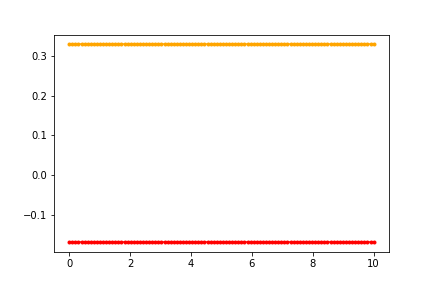

In [29]:
plt.plot(t, g_order0.real, marker='o', markersize=3, color='red')
plt.plot(t, g_order0.imag, marker='o', markersize=3, color='orange')
plt.show()

### Order 1 Calculation

In [30]:
my_integrand([0.00])

(-2.6355421510262933e-06-1.4398038549329195e-06j)

In [31]:
t = np.linspace(0.0,10.0,500)
t_list = [list([t0]) for t0 in t]
g_order1 = np.array(map(my_integrand, t_list))


# From Analytic
g_order1_diags = np.zeros(len(t), dtype='c16')
for i_t in range(len(t)):
    g_order1_diags[i_t] = g_d1(kp_ext_1, kp_ext_2, t[i_t])

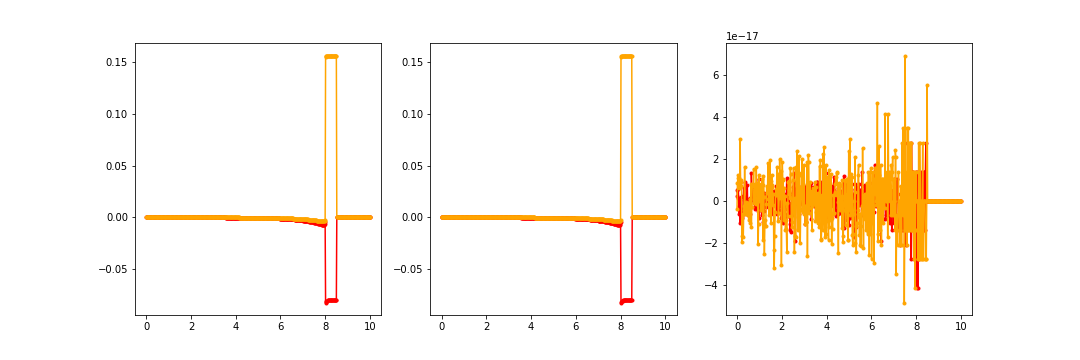

In [32]:
fig = plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,3,1)
ax0.plot(t, g_order1.real, marker='o', markersize=3, color='red')
ax0.plot(t, g_order1.imag, marker='o', markersize=3, color='orange')

ax1 = plt.subplot(1,3,2)
ax1.plot(t, g_order1_diags.real, marker='o', markersize=3, color='red') # check sign  - g_order1.real + 
ax1.plot(t, g_order1_diags.imag, marker='o', markersize=3, color='orange') # check sign - g_order1.imag + 


ax2 = plt.subplot(1,3,3)
ax2.plot(t, - g_order1.real +  g_order1_diags.real, marker='o', markersize=3, color='red') # check sign  - g_order1.real + 
ax2.plot(t, - g_order1.imag +  g_order1_diags.imag, marker='o', markersize=3, color='orange') # check sign - g_order1.imag + 


# ax1.set_yscale('log')
plt.show()

### Order 2 Calculation

In [56]:
t = np.linspace(0.0, 9.0, 100)
t_list = [list([t0, t0]) for t0 in t]
g_order2 = np.array(map(my_integrand, t_list))

# From Analytic
g_order2_diags = np.zeros(len(t), dtype='c16')
for i_t in range(len(t)):
    g_order2_diags[i_t] = g_d2(kp_ext_1, kp_ext_2, t[i_t], t[i_t]+1e-12)

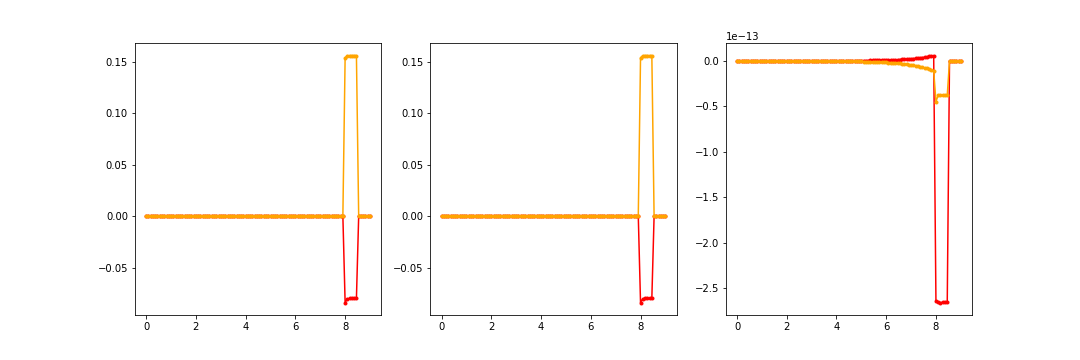

In [57]:
fig = plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,3,1)
ax0.plot(t, g_order2.real, marker='o', markersize=3, color='red')
ax0.plot(t, g_order2.imag, marker='o', markersize=3, color='orange')

ax1 = plt.subplot(1,3,2)
ax1.plot(t, g_order2_diags.real, marker='o', markersize=3, color='red') # check sign  - g_order1.real + 
ax1.plot(t, g_order2_diags.imag, marker='o', markersize=3, color='orange') # check sign - g_order1.imag + 


ax2 = plt.subplot(1,3,3)
ax2.plot(t, - g_order2.real +  g_order2_diags.real, marker='o', markersize=3, color='red') # check sign  - g_order1.real + 
ax2.plot(t, - g_order2.imag +  g_order2_diags.imag, marker='o', markersize=3, color='orange') # check sign - g_order1.imag + 


# ax1.set_yscale('log')
plt.show()

In [43]:
t_list = []
t_max = 10.0

nr_sample_edge = 100
delta_t = t_max / nr_sample_edge

for i_t1 in range(nr_sample_edge):
    for i_t2 in range(0, i_t1):
        t_list.append([delta_t * i_t2, delta_t * i_t1])
g_order2 = np.array(map(my_integrand, t_list))

In [44]:
# g_order2

In [45]:
1+1

2

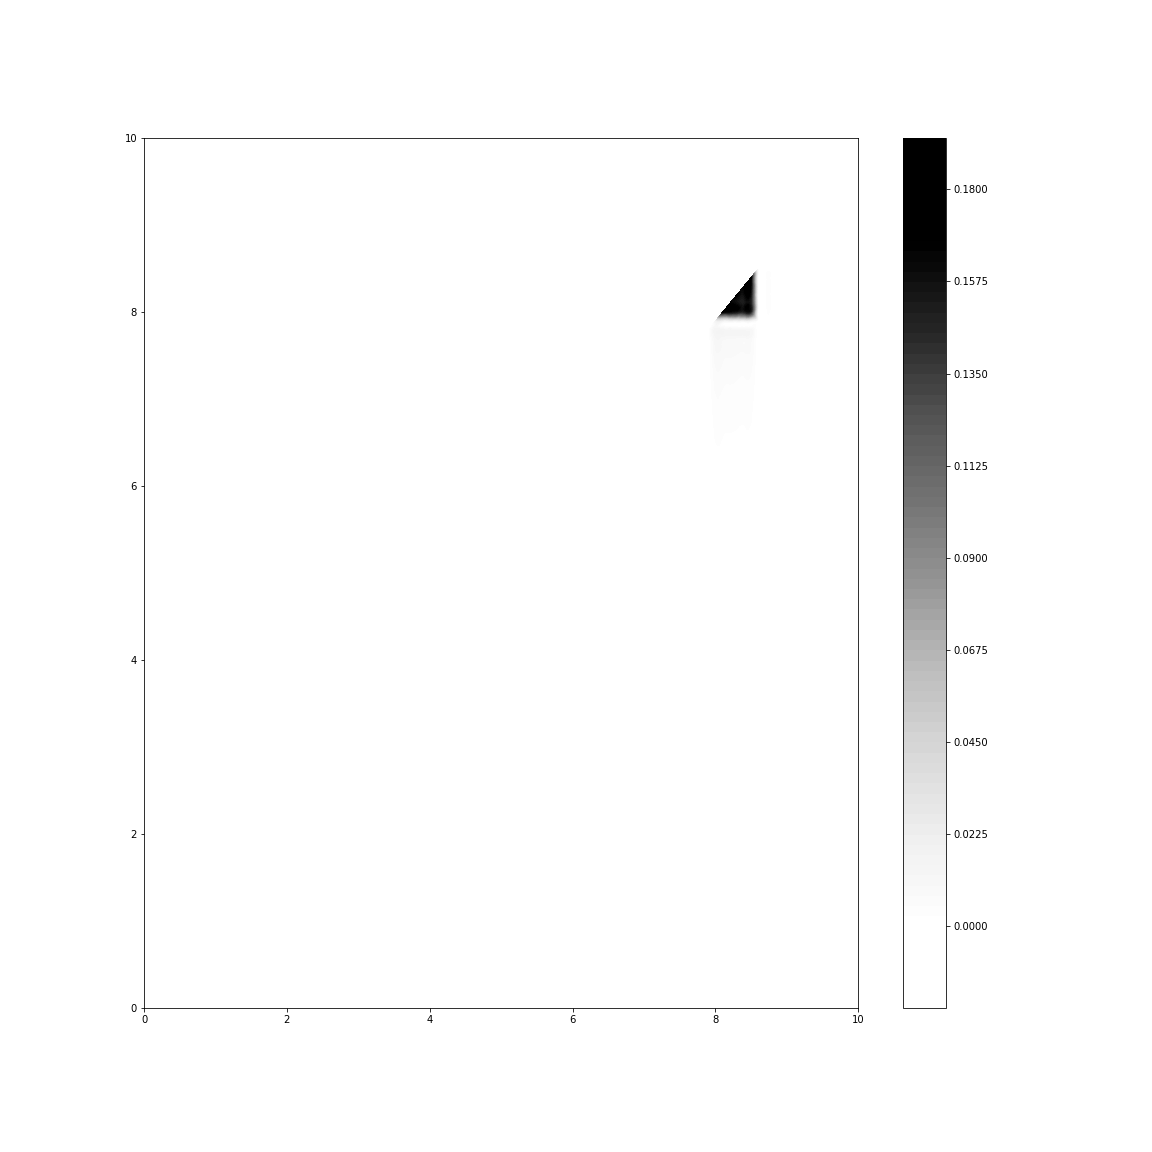

In [46]:
# # plt.plot(t_list, g_order2.real, marker='o', markersize=3)

# X, Y = np.meshgrid(, np.array(t_list)[:,1])

# plt.contour(X, Y, g_order2.real)#, marker='o', markersize=3)

x = np.array(t_list)[:,1]
y = np.array(t_list)[:,0]
z = np.abs(g_order2)

from scipy.interpolate import griddata


xi = np.linspace(0.0,10.0,500)
yi = np.linspace(0.0,10.0,500)

zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')


fig = plt.figure(figsize=(16,16))

# plt.contour(xi,yi,zi,linewidths=0.5,colors='k', vmin=z.min(), vmax=z.max())
plt.contourf(xi,yi,zi, 100,cmap=plt.cm.Greys, vmin=z.min(), vmax=z.max())
plt.colorbar() # draw colorbar
# plot data points.
# plt.scatter(x,y,marker='o',c='b', s=0.5)
# plt.xlim(-2,2)
# plt.ylim(-2,2)
# plt.title('griddata test (%d points)' % npts)
plt.show()

## Run a Measurement

In [ ]:
computer = k_imp.ComputeChargeQ(2, 9.0, my_model.param_, 10000)

In [ ]:
computer.run(10)

In [ ]:
computer.reduce_result()

## Factorial vs Power Nr of Operations

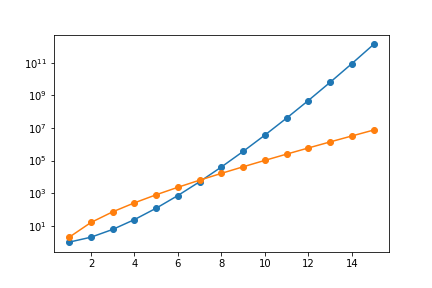

In [42]:
## Figure out exact FLOP scaling

x = np.linspace(1,15,15, dtype=int)
y_fac = map(np.math.factorial, x)#.linspace(1,10,10, dtype=int)
y_det = np.power(2, x) * np.square(x)

plt.plot(x, y_fac, marker='o')
plt.plot(x, y_det,  marker='o')
plt.yscale('log')

In [137]:
1+1

2